# 1. 가스,전기,지역난방 사용량 컬럼 생성

## 1.0 함수 정의

In [38]:
# 행정동명 일치 확인 함수
def check_adm_nm_match(df_gas, df_reference):
    """
    가스 데이터의 '행정동명'과 기존 데이터의 'ADM_NM'이 일치하는지 확인
    
    Parameters:
    -----------
    df_gas : 가스 사용량 데이터, df_reference : 기존 데이터 (ADM_NM 컬럼 포함)
    
    Returns:
    --------
    dict : 매칭 결과 정보
    """
    
    # 각 데이터프레임의 고유 행정동명 추출
    gas_adm = set(df_gas['행정동명'].unique())
    ref_adm = set(df_reference['ADM_NM'].unique())
    
    # 일치하는 것
    matched = gas_adm & ref_adm
    
    # 가스 데이터에만 있는 것
    only_in_gas = gas_adm - ref_adm
    
    # 기존 데이터에만 있는 것
    only_in_ref = ref_adm - gas_adm
    
    result = {
        'total_gas': len(gas_adm),
        'total_ref': len(ref_adm),
        'matched': len(matched),
        'only_in_gas': sorted(list(only_in_gas)),
        'only_in_ref': sorted(list(only_in_ref)),
        'match_rate': len(matched) / len(ref_adm) * 100 if len(ref_adm) > 0 else 0
    }
    
    return print(result)

In [39]:
# 행정동명 표준화 함수
def standardize_adm_name(name):
    """가스 데이터 행정동명을 ADM_NM 형식으로 변환"""
    if pd.isna(name):
        return name
    
    name = str(name)
    
    # . -> · 변환
    name = name.replace('.', '·')
    
    # 특수케이스들 (제를 제거하지 않음)
    special_cases = ['제기동', '홍제1동', '홍제2동', '홍제3동']
    if name in special_cases:
        return name
    
    # 특수케이스: 창제X동 -> 창X동
    if name.startswith('창제'):
        return name.replace('창제', '창')
    
    # 나머지: ~제X동 -> ~X동
    # 예: 가양제1동 -> 가양1동, 면목제3·8동 -> 면목3·8동
    import re
    name = re.sub(r'제(\d+[·\d]*동)', r'\1', name)
    
    return name

In [46]:
# 사용량 데이터를 전처리하는 함수
import numpy as np
def preprocess_gas_data(df, year, name):
    """
    Parameters:
    -----------
    df : DataFrame
        원본 가스 사용량 데이터 (wide format)
    year : int
        데이터의 연도 (2020~2025)
    name: str 설정할 컬럼명 (예: '가스_사용량')
    """
    
    # 1. 복사본 생성
    df_processed = df.copy()

    # 5. 월별 컬럼들을 Long format으로 변환
    # id_vars: 유지할 컬럼들
    # value_vars: 녹여서 하나로 만들 컬럼들 (1월~12월)
    # var_name: 월 컬럼명
    # value_name: 값 컬럼명
    
    month_cols = ['1월', '2월', '3월', '4월', '5월', '6월', 
                  '7월', '8월', '9월', '10월', '11월', '12월']
    
    # 실제 존재하는 월 컬럼만 선택
    available_month_cols = [col for col in month_cols if col in df_processed.columns]
    
    id_vars = ['자치구명', '행정동명']
    
    df_melted = pd.melt(
        df_processed,
        id_vars=id_vars,
        value_vars=available_month_cols,
        var_name='month_str',
        value_name=name
    )
    
    # 6. month 컬럼 생성 (1월 -> 1, 2월 -> 2, ...)
    df_melted['month'] = df_melted['month_str'].str.replace('월', '').astype(int)
    
    # 7. year 컬럼 추가
    df_melted['year'] = year
    
    # 8. month_str 컬럼 삭제
    df_melted = df_melted.drop('month_str', axis=1)
    
    # 9. 컬럼 순서 재정렬
    df_melted = df_melted[['자치구명', '행정동명', 'year', 'month', name]]
    
    # 10. 가스_사용량을 숫자형으로 변환 (문자열일 경우 대비)
    df_melted[name] = pd.to_numeric(df_melted[name], errors='coerce')
    
    return df_melted

In [51]:
#여러 연도의 데이터를 하나로 합치는 함수 : long format 변환 함수 포함
def combine_all_years(df_list, years, name):
    """
    여러 연도의 데이터를 하나로 합치기
    
    Parameters:
    -----------
    df_list : list of DataFrame
        각 연도별 원본 데이터프레임 리스트
    years : list of int
        각 데이터프레임에 해당하는 연도 리스트
    
    Returns:
    --------
    DataFrame : 전체 연도가 합쳐진 데이터
    """
    
    processed_dfs = []
    
    for df, year in zip(df_list, years):
        df_processed = preprocess_gas_data(df, year, name)
        processed_dfs.append(df_processed)
        print(f"{year}년 데이터 처리 완료: {len(df_processed)} rows")
    
    # 모든 연도 데이터 합치기
    df_combined = pd.concat(processed_dfs, ignore_index=True)
    
    print(f"\n전체 데이터: {len(df_combined)} rows")
    print(f"연도별 분포:\n{df_combined['year'].value_counts().sort_index()}")
    
    return df_combined

## 1.1 가스_사용량 컬럼 만들기

In [67]:
import pandas as pd
base_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\landsat8_추출_데이터\lst_final_20_24.csv")
gas_20 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_가스\energyUse_data_2020.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_21 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_가스\energyUse_data_2021.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_22 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_가스\energyUse_data_2022.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_23 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_가스\energyUse_data_2023.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_24 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_가스\energyUse_data_2024.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)

c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains

In [68]:
print('-'*20)
print('2020년 확인 - before')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20['행정동명'] = gas_20['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2020년 확인 - after')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20.info()
display(gas_20.head())

print('-'*20)
print('2021년 확인')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21['행정동명'] = gas_21['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2021년 확인 - after')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21.info()
display(gas_21.head())

print('-'*20)
print('2022년 확인')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22['행정동명'] = gas_22['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2022년 확인 - after')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22.info()
display(gas_22.head())

print('-'*20)
print('2023년 확인')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23['행정동명'] = gas_23['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2023년 확인 - after')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23.info()
display(gas_23.head())

print('-'*20)
print('2024년 확인')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24['행정동명'] = gas_24['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2024년 확인 - after')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24.info()
display(gas_24.head())

--------------------
2020년 확인 - before
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,741.964707,693.137555,666.911968,667.949646,623.559772,658.265336,705.325165,729.453232,371.670528,671.004687,667.243980,694.618446
1,강남구,개포2동,195.592346,195.884110,153.262780,117.621351,80.600046,56.412295,50.497254,48.117261,40.594196,52.303112,99.163032,150.749542
2,강남구,개포3동,94.528674,86.812914,79.403802,60.429257,56.480845,46.493166,63.547515,56.432409,64.704989,37.649331,56.083122,63.491526
3,강남구,개포4동,1175.103620,1196.462862,934.411179,655.560125,415.521983,237.518084,189.973103,204.621985,167.516138,289.483914,621.782376,1053.988313
4,강남구,논현1동,2756.213041,2871.920504,2245.210382,1586.683628,944.146534,575.945052,590.233492,627.859612,547.401366,685.637779,1256.112626,2252.579361


--------------------
2021년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,695.152104,683.283174,618.635967,692.717896,678.169631,685.964156,716.622607,755.258484,723.808881,668.068273,693.187444,708.201336
1,강남구,개포2동,221.310815,162.570043,182.446332,120.404211,83.556256,63.109002,52.319080,44.079331,44.696131,54.190094,98.329191,149.658128
2,강남구,개포3동,65.804949,68.651920,72.033363,68.732652,55.217980,46.600687,47.535318,54.372064,47.224618,31.498342,46.510805,54.695139
3,강남구,개포4동,1452.385505,1171.520005,868.170291,628.448042,403.271823,266.579381,206.966847,160.051485,171.711405,253.195809,634.835862,995.872979
4,강남구,논현1동,3268.981630,2827.316687,2154.393123,1420.912227,858.868053,593.485823,545.152082,549.691490,550.592382,615.586976,1237.994934,2121.013151


--------------------
2022년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,762.368357,721.951404,647.272840,684.263781,678.582282,710.093255,704.419000,747.537588,732.887587,675.696497,677.603380,675.262927
1,강남구,개포2동,212.176172,214.723421,172.763602,126.197990,76.017807,56.456879,58.225903,52.106751,47.453367,64.813615,94.668323,150.733025
2,강남구,개포3동,76.989601,72.491135,66.862227,56.543018,50.805510,39.873003,47.596852,49.493816,46.130876,38.930933,48.476895,54.403502
3,강남구,개포4동,1389.355293,1316.517966,990.536887,699.770296,357.719395,229.695573,194.090420,178.302334,195.718993,294.380419,579.160204,1010.294712
4,강남구,논현1동,3111.817652,3070.408130,2325.291022,1569.460729,777.384176,576.322288,579.808059,612.336275,631.209410,705.248466,1172.923722,2107.747979


--------------------
2023년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,721.718193,682.072772,630.636863,670.969871,646.159948,670.281218,681.097876,671.079583,685.053138,630.393462,620.988461,658.888126
1,강남구,개포2동,244.012438,252.947373,167.137935,125.493389,91.508174,64.325846,60.619213,57.581214,56.603343,56.542403,95.020787,176.600735
2,강남구,개포3동,84.335827,76.242626,72.125433,62.625455,50.646683,48.161853,52.224302,57.884505,52.350735,42.501027,53.178618,72.984713
3,강남구,개포4동,1227.727083,1328.928309,810.250959,555.573658,365.616507,245.329033,190.381225,178.833577,183.019113,251.825501,540.114464,975.077306
4,강남구,논현1동,2841.970825,3240.720511,1894.851401,1276.166818,792.432709,561.268172,544.380464,569.091768,608.282625,582.863842,1113.829858,2120.619703


--------------------
2024년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,689.781279,663.350314,611.692749,642.685455,626.958393,657.333519,676.972889,716.432809,722.187774,678.703700,666.559119,694.215038
1,강남구,개포2동,380.662133,190.737813,180.377616,128.747023,75.922189,64.989720,61.125803,59.793327,52.316827,62.752429,81.644832,147.846332
2,강남구,개포3동,111.762834,78.633982,73.182553,72.367486,50.076436,41.689807,51.001505,48.407219,45.732730,46.437613,48.505086,64.307277
3,강남구,개포4동,1264.528217,1113.386824,866.814769,576.781187,310.705742,215.333643,178.407622,172.093893,130.967869,218.961905,432.347796,924.686648
4,강남구,논현1동,2983.844057,2707.622766,2144.927908,1342.079925,707.591360,558.006341,563.432985,603.093140,515.539771,636.383186,885.564414,1927.985415


In [ ]:
df_list = [gas_20, gas_21, gas_22, gas_23, gas_24]
years = [2020, 2021, 2022, 2023, 2024]
combine_all_years(df_list, years, '에너지사용량_가스') #데이터 형태 변형 + 합치기
# combine_all_years(df_list, years, '에너지사용량_가스').to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 최종\가스_에너지사용량_최종.csv", index=False, encoding='utf-8-sig')

2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64
2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64


In [ ]:
final_df = combine_all_years(df_list, years, '에너지사용량_가스')
final_df.info()

2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64


## 1.2 전기_사용량 컬럼 만들기

In [72]:
import pandas as pd
base_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\landsat8_추출_데이터\lst_final_20_24.csv")
gas_20 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_전기\energyUse_data_2020_전기.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_21 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_전기\energyUse_data_2021_전기.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_22 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_전기\energyUse_data_2022_전기.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_23 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_전기\energyUse_data_2023_전기.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_24 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_전기\energyUse_data_2024_전기.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)

c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains

In [ ]:
# 연도별 행정동명 일치 확인 및 표준화

print('-'*20)
print('2020년 확인 - before')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20['행정동명'] = gas_20['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2020년 확인 - after')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20.info()
display(gas_20.head())

print('-'*20)
print('2021년 확인')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21['행정동명'] = gas_21['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2021년 확인 - after')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21.info()
display(gas_21.head())

print('-'*20)
print('2022년 확인')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22['행정동명'] = gas_22['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2022년 확인 - after')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22.info()
display(gas_22.head())

print('-'*20)
print('2023년 확인')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23['행정동명'] = gas_23['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2023년 확인 - after')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23.info()
display(gas_23.head())

print('-'*20)
print('2024년 확인')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24['행정동명'] = gas_24['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2024년 확인 - after')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24.info()
display(gas_24.head())

--------------------
2020년 확인 - before
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,1397.864,1371.242,1231.832,1177.624,1067.438,1186.167,1215.570,1444.988,1320.908,1099.223,1261.661,1411.226
1,강남구,개포2동,4626.067,4483.347,4021.669,3852.430,3807.383,4275.913,4518.314,5450.923,4344.913,3852.598,4109.579,4486.263
2,강남구,개포3동,14397.221,13237.353,11363.763,10049.602,9063.899,9139.335,9544.457,9982.509,9204.567,9233.228,10650.241,14047.829
3,강남구,개포4동,6647.946,6562.507,5686.268,5098.238,4460.616,4956.730,5797.106,6466.929,5934.979,4809.671,5475.120,6532.142
4,강남구,논현1동,20902.263,20263.628,17902.558,15891.510,14182.363,16285.074,18976.941,20546.804,18246.513,14850.095,15056.689,17919.068


--------------------
2021년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,1529.778,1420.287,1196.090,1226.668,1125.812,1205.317,1516.460,1720.063,1249.303,1135.196,1248.857,1354.894
1,강남구,개포2동,4902.823,4575.002,4357.156,4338.502,4130.448,4767.891,6300.398,7230.316,5581.125,5186.712,5285.252,5756.920
2,강남구,개포3동,16970.936,13525.891,11213.094,10239.535,10319.688,10169.839,11362.804,11783.890,10477.427,11048.005,14974.016,18612.084
3,강남구,개포4동,7842.849,7836.617,6263.749,5857.066,5357.601,5896.348,7165.664,9003.140,7068.012,5950.322,6407.038,7157.719
4,강남구,논현1동,22154.542,20765.968,16764.095,15208.343,13838.690,15725.434,19361.219,23762.117,19023.425,15574.854,15155.149,17970.488


--------------------
2022년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,1528.989,1483.337,1271.151,1292.854,1161.980,1263.123,1662.922,1788.628,1345.911,1195.342,1296.756,1448.583
1,강남구,개포2동,6458.454,6139.225,5461.540,5219.772,5293.330,5529.564,7300.579,7613.798,5919.206,5280.698,5539.334,6210.967
2,강남구,개포3동,20757.796,18931.440,15854.298,12322.902,10557.268,10693.565,11836.966,11669.913,10406.363,11357.395,13132.008,18592.693
3,강남구,개포4동,8354.532,8150.787,7210.506,6340.369,5515.758,6116.226,7816.494,8759.903,7282.277,5914.093,5968.232,7293.847
4,강남구,논현1동,22428.529,21940.724,18260.813,15951.178,14336.672,16633.165,20847.562,23542.242,20032.406,16094.135,15132.262,18784.592


--------------------
2023년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,1633.396,1566.755,1299.269,1337.764,1258.780,1386.396,1728.961,2192.651,1839.953,1423.655,1563.762,1748.019
1,강남구,개포2동,6695.729,6225.375,5518.174,5357.973,5305.514,5909.965,7505.664,8654.046,7038.141,5618.546,5795.648,6516.256
2,강남구,개포3동,18787.343,16563.593,13630.605,11091.091,10437.274,10164.225,11234.411,11767.791,10809.002,10698.725,14164.892,19479.346
3,강남구,개포4동,8705.976,8034.019,6569.388,5933.703,5542.796,6136.652,7507.294,8934.013,7966.813,5900.682,5959.440,7326.716
4,강남구,논현1동,23938.084,22414.636,17283.713,15515.254,14406.344,17120.642,20411.887,23982.115,22274.635,15919.009,15509.183,18873.427


--------------------
2024년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,1957.830,1839.822,1786.046,1570.412,1435.142,1618.070,2104.368,2665.665,2297.938,1805.881,1865.295,2178.034
1,강남구,개포2동,6889.423,6446.748,5991.508,5638.583,5467.002,6151.763,7656.430,9773.910,8349.500,6081.417,5853.947,6538.197
2,강남구,개포3동,21414.802,19109.142,15753.503,11526.512,10078.976,9984.962,11108.912,11813.982,10922.728,10249.647,11463.394,18670.872
3,강남구,개포4동,8025.912,7789.349,6712.814,6098.980,5403.252,6043.465,7564.948,9300.806,8892.245,6452.108,5783.775,6936.008
4,강남구,논현1동,22670.179,21786.259,18101.167,16050.872,14507.614,17058.707,20633.574,25136.812,24312.615,18240.481,16031.783,19124.376


In [ ]:
# 여러 연도의 데이터를 하나로 병합
df_list = [gas_20, gas_21, gas_22, gas_23, gas_24]
years = [2020, 2021, 2022, 2023, 2024]
combine_all_years(df_list, years, '에너지사용량_전기') #데이터 형태 변형 + 합치기
combine_all_years(df_list, years, '에너지사용량_전기').to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 최종\전기_에너지사용량_최종.csv", index=False, encoding='utf-8-sig')

2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64
2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64


## 1.3 지역난방_사용량 컬럼 만들기

In [76]:
import pandas as pd
base_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\landsat8_추출_데이터\lst_final_20_24.csv")
gas_20 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_지역난방\energyUse_data_난방_20.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_21 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_지역난방\energyUse_data_난방_21.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_22 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_지역난방\energyUse_data_난방_22.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_23 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_지역난방\energyUse_data_난방_23.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)
gas_24 = pd.read_excel(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 사용량_지역난방\energyUse_data_난방_24.xlsx", header=1).drop(index=0, columns=['번호','계']).reset_index(drop=True)

c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\cub72\anaconda3\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains

In [ ]:
# 연도별 행정동명 일치 확인 및 표준화
print('-'*20)
print('2020년 확인 - before')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20['행정동명'] = gas_20['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2020년 확인 - after')
check_adm_nm_match(gas_20, base_df) #행정동명 일치 확인 함수
gas_20.info()
display(gas_20.head())

print('-'*20)
print('2021년 확인')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21['행정동명'] = gas_21['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2021년 확인 - after')
check_adm_nm_match(gas_21, base_df) #행정동명 일치 확인 함수
gas_21.info()
display(gas_21.head())

print('-'*20)
print('2022년 확인')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22['행정동명'] = gas_22['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2022년 확인 - after')
check_adm_nm_match(gas_22, base_df) #행정동명 일치 확인 함수
gas_22.info()
display(gas_22.head())

print('-'*20)
print('2023년 확인')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23['행정동명'] = gas_23['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2023년 확인 - after')
check_adm_nm_match(gas_23, base_df) #행정동명 일치 확인 함수
gas_23.info()
display(gas_23.head())

print('-'*20)
print('2024년 확인')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24['행정동명'] = gas_24['행정동명'].apply(standardize_adm_name) #행정동명 표준화 함수 적용
print('2024년 확인 - after')
check_adm_nm_match(gas_24, base_df) #행정동명 일치 확인 함수
gas_24.info()
display(gas_24.head())

--------------------
2020년 확인 - before
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,3529.18,3141.11,2384.32,1598.29,580.56,327.04,307.44,313.42,350.72,1114.21,2185.26,3768.28
1,강남구,개포2동,9270.30,8298.00,6564.30,4745.80,2419.80,1188.90,1153.20,1136.30,1265.90,3341.20,5852.60,9821.90
2,강남구,개포3동,7855.22,6974.74,5354.06,3722.43,1737.84,1271.57,1311.10,1515.41,1078.70,2675.95,4959.82,8695.77
3,강남구,개포4동,1584.30,1431.40,1100.20,804.30,335.30,131.80,122.60,122.10,189.10,618.50,1059.30,1786.50
4,강남구,논현1동,780.00,691.60,540.40,370.40,209.60,124.20,106.50,104.80,111.20,230.40,434.00,804.10


--------------------
2021년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,4302.56,3061.62,2130.31,1093.3,644.2,391.2,282.6,246.7,316.7,1011.38,2194.55,3667.07
1,강남구,개포2동,11279.80,8425.00,6238.40,3723.1,2857.1,1527.3,1448.1,955.1,1451.0,3797.21,7500.49,11841.31
2,강남구,개포3동,9879.26,7188.38,5248.93,3131.7,2118.9,1326.2,1468.2,1137.6,1063.7,2492.49,5020.87,8354.31
3,강남구,개포4동,1977.60,1520.40,1024.20,635.8,414.7,136.4,104.5,359.2,510.3,1346.90,2552.40,4342.90
4,강남구,논현1동,941.50,690.00,514.60,310.5,234.6,150.0,109.0,88.8,116.2,219.10,447.00,774.80


--------------------
2022년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,4362.45,3727.18,2516.71,1234.81,616.55,405.29,339.19,330.32,386.75,1142.75,1923.36,4469.08
1,강남구,개포2동,13619.60,11887.73,8945.73,4768.82,2688.65,1747.68,1414.30,1348.54,1729.24,4254.49,6546.58,13560.47
2,강남구,개포3동,9571.97,8195.95,5781.36,3105.79,1839.61,1219.78,1386.23,1263.74,1064.01,2648.72,4159.03,9352.96
3,강남구,개포4동,4884.30,4312.40,3272.40,1822.80,1124.60,650.80,533.30,496.60,608.00,1523.60,2276.90,4863.90
4,강남구,논현1동,917.20,788.90,594.30,327.60,205.00,138.80,111.80,109.30,129.20,240.00,381.10,872.60


--------------------
2023년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,4256.96,3090.22,2129.22,1227.90,531.28,377.72,369.19,301.81,375.27,1050.38,2722.02,4328.51
1,강남구,개포2동,13352.74,9935.37,7289.43,4637.87,2874.12,1636.10,1465.52,1166.36,1368.64,3461.70,7817.12,11873.94
2,강남구,개포3동,9093.89,6714.56,4655.41,2806.05,1694.07,1123.43,1378.92,1221.70,1061.74,2123.11,5076.63,7999.71
3,강남구,개포4동,4732.70,3475.20,2536.20,1629.60,1016.20,639.90,563.70,442.20,524.70,1182.80,2680.70,4230.30
4,강남구,논현1동,871.00,651.50,469.30,292.80,202.50,136.40,138.00,131.10,127.00,192.80,455.60,797.20


--------------------
2024년 확인
{'total_gas': 425, 'total_ref': 425, 'matched': 240, 'only_in_gas': ['가양제1동', '가양제2동', '가양제3동', '갈현제1동', '갈현제2동', '개봉제1동', '개봉제2동', '개봉제3동', '고덕제1동', '고덕제2동', '고척제1동', '고척제2동', '구로제1동', '구로제2동', '구로제3동', '구로제4동', '구로제5동', '구의제1동', '구의제2동', '구의제3동', '금호2.3가동', '길음제1동', '길음제2동', '남가좌제1동', '남가좌제2동', '노량진제1동', '노량진제2동', '답십리제1동', '답십리제2동', '당산제1동', '당산제2동', '대림제1동', '대림제2동', '대림제3동', '도봉제1동', '도봉제2동', '독산제1동', '독산제2동', '독산제3동', '독산제4동', '돈암제1동', '돈암제2동', '둔촌제1동', '둔촌제2동', '등촌제1동', '등촌제2동', '등촌제3동', '망우제3동', '망원제1동', '망원제2동', '면목제2동', '면목제3.8동', '면목제4동', '면목제5동', '면목제7동', '명일제1동', '명일제2동', '묵제1동', '묵제2동', '발산제1동', '방학제1동', '방학제2동', '방학제3동', '방화제1동', '방화제2동', '방화제3동', '북가좌제1동', '북가좌제2동', '불광제1동', '불광제2동', '사당제1동', '사당제2동', '사당제3동', '사당제4동', '사당제5동', '상계3.4동', '상계6.7동', '상도제1동', '상도제2동', '상도제3동', '상도제4동', '상봉제1동', '상봉제2동', '성내제1동', '성내제2동', '성내제3동', '성산제1동', '성산제2동', '성수1가제1동', '성수1가제2동', '성수2가제1동', '성수2가제3동', '숭인제1동', '숭인제2동', '시흥제1동', '시흥제2동', '시흥제3동', '시흥제4동',

,자치구명,행정동명,1월,2월,3월,4월,5월,6월,7월,8월,9월,10월,11월,12월
0,강남구,개포1동,4106.27,3605.83,2911.11,1063.48,749.29,527.88,457.21,344.49,365.11,1006.58,2521.57,5125.82
1,강남구,개포2동,12932.41,9915.12,8762.71,4041.51,2846.31,1623.00,1386.44,1060.86,1137.37,2866.61,6271.19,11785.43
2,강남구,개포3동,8770.78,6625.00,5662.32,2477.01,1748.55,1341.22,1417.71,1405.57,1089.70,1621.43,3930.55,7953.03
3,강남구,개포4동,4416.90,3378.60,2860.50,1369.20,991.40,629.60,525.70,409.30,431.90,986.70,2192.20,4177.50
4,강남구,논현1동,882.80,687.00,559.20,269.60,211.70,186.70,0.00,0.00,0.00,0.00,0.00,0.00


In [79]:
df_list = [gas_20, gas_21, gas_22, gas_23, gas_24]
years = [2020, 2021, 2022, 2023, 2024]
combine_all_years(df_list, years, '에너지사용량_지역난방') #데이터 형태 변형 + 합치기
combine_all_years(df_list, years, '에너지사용량_지역난방').to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 최종\지역난방_에너지사용량_최종.csv", index=False, encoding='utf-8-sig')

2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64
2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64


In [ ]:
# 여러 연도의 데이터를 하나로 병합
final_df = combine_all_years(df_list, years, '에너지사용량_지역난방')
final_df.info()

2020년 데이터 처리 완료: 5112 rows
2021년 데이터 처리 완료: 5112 rows
2022년 데이터 처리 완료: 5112 rows
2023년 데이터 처리 완료: 5112 rows
2024년 데이터 처리 완료: 5112 rows

전체 데이터: 25560 rows
연도별 분포:
year
2020    5112
2021    5112
2022    5112
2023    5112
2024    5112
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25560 entries, 0 to 25559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   자치구명         25560 non-null  object 
 1   행정동명         25560 non-null  object 
 2   year         25560 non-null  int64  
 3   month        25560 non-null  int64  
 4   에너지사용량_지역난방  25560 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 998.6+ KB


In [ ]:
# 에너지사용량_지역난방이 0인 행 확인
cond = (final_df['에너지사용량_지역난방']== 0.000000)
k = final_df.loc[cond]
k
k['month'].value_counts().sum()

np.int64(17563)

## 1.4 null값 확인

In [84]:
df_gas = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 최종\가스_에너지사용량_최종.csv")

In [88]:
cond = (df_gas['에너지사용량_가스']== 0.000000)
k = df_gas.loc[cond]
k
# k['month'].value_counts()

,자치구명,행정동명,year,month,에너지사용량_가스


In [89]:
df_elc = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\에너지 최종\전기_에너지사용량_최종.csv")
cond = (df_elc['에너지사용량_전기']== 0.000000)
k = df_elc.loc[cond]
k
# k['month'].value_counts()

,자치구명,행정동명,year,month,에너지사용량_전기


In [3]:
import pandas as pd
df_arc = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\서울시 건축인허가 기본개요.csv", encoding='cp949')

In [9]:
# 한 번만
!pip install geopandas pyproj fiona shapely


   ---------------------------------------- 0.0/24.5 MB ? eta -:--:--
   --- ------------------------------------ 1.8/24.5 MB 8.9 MB/s eta 0:00:03
   --------- ------------------------------ 5.8/24.5 MB 14.6 MB/s eta 0:00:02
   ------------------ --------------------- 11.0/24.5 MB 18.1 MB/s eta 0:00:01
   --------------------------- ------------ 16.8/24.5 MB 20.4 MB/s eta 0:00:01
   ---------------------------------------- 24.5/24.5 MB 23.9 MB/s eta 0:00:00

   -------------------------- ------------- 2/3 [fiona]
   -------------------------- ------------- 2/3 [fiona]
   ---------------------------------------- 3/3 [fiona]



In [22]:
import re, pandas as pd, geopandas as gpd, pathlib

fix_path = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\gis건물통합정보\AL_D010_11_20241204.fix"
shp_path = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\gis건물통합정보\AL_D010_11_20241204.shp"

# 1) 바이너리 → cp949 디코딩, 망가진 바이트 무시
raw_txt = pathlib.Path(fix_path).read_bytes().decode('cp949', errors='ignore')

# 2) 정규식으로 "A0\t건물명" 형태 추출
mapping = dict(re.findall(r'(A\d+)\s+([^\t\r\n]+)', raw_txt))
print(list(mapping.items())[:5])   # 매핑 결과 확인

# 3) SHP 읽고 컬럼명 바꾸기
gdf = gpd.read_file(shp_path, encoding='cp949', engine='pyogrio')
gdf = gdf.rename(columns=mapping)

# 4) 확인
print(gdf.head(3).T)


[]
                                                          0  \
A0                                                       32   
A1                             1991201839054527769900000000   
A2                                      1111017500107040000   
A3                                               1111017500   
A4                                            서울특별시 종로구 숭인동   
A5                                                      704   
A6                                                        1   
A7                                                       일반   
A8                                                    01000   
A9                                                     단독주택   
A10                                                      39   
A11                                                   기타강구조   
A12                                                    57.6   
A13                                              1991-09-02   
A14                                                 

In [19]:
from pathlib import Path
import pandas as pd

fix_path = Path(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\gis건물통합정보\AL_D010_11_20241204.fix")

mapping = {}
with open(fix_path, encoding='utf-8') as f:
    for line in f:
        # 보통: 인덱스 \t 한글필드명 \t 타입 \t 길이 …
        parts = line.strip().split('\t')
        if len(parts) >= 2 and parts[0].startswith('A'):
            mapping[parts[0]] = parts[1].strip()

# 예시 확인
print({k: mapping[k] for k in list(mapping)[:5]})

import geopandas as gpd

shp = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\gis건물통합정보\AL_D010_11_20241204.shp"
gdf = gpd.read_file(shp, encoding='euc-kr', engine='pyogrio')  # 빠른 엔진 권장

# 매핑 적용
gdf = gdf.rename(columns=mapping)

# geometry 빼고 3개만 미리 확인
print(gdf[['건물명', '소재지지번', '연면적']].head())


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x9e in position 7: invalid start byte

# 2. 용적률 컬럼 생성 (재정의 - 최종)

### 사전 작업 (행정동-법정동 매핑 확인)

In [86]:
df_mapping = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv")
ex_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\landsat8_추출_데이터\lst_final_20_24.csv")
ex_df['ADM_NM'].unique()

# ADM_NM 유일값 비교
set1 = set(ex_df['ADM_NM'].dropna().unique())
set2 = set(df_m['ADM_NM'].dropna().unique())

if set1 == set2:
    print("두 데이터프레임의 유일값이 동일합니다. 총 개수:", len(set1))
else:
    only_in_df = sorted(set1 - set2)
    only_in_df2 = sorted(set2 - set1)
    print("유일값이 다릅니다.")
    print(f"df_m에만 있는 값 ({len(only_in_df)}):", only_in_df)
    print(f"df_mapping에만 있는 값 ({len(only_in_df2)}):", only_in_df2)

두 데이터프레임의 유일값이 동일합니다. 총 개수: 425


In [ ]:
df_mapping = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv")
display(df_mapping.head())
# 행정동명 정규화
# df_mapping['행정동명'] = df_mapping['행정동명'].str.replace('.', '·', regex=False)  # 마침표 → 가운뎃점

# # '제' 제거 (단, '제기동', '홍제'는 보호)
# df_mapping['행정동명'] = df_mapping['행정동명'].apply(
#     lambda x: x.replace('제', '') if x not in ['제기동', '홍제1동', '홍제2동', '홍제3동'] 
#     and '홍제' not in x and x != '제기동' 
#     else x
# )

# # 개별 치환 (홍제만)
# df_mapping['행정동명'] = df_mapping['행정동명'].str.replace('홍제제1동', '홍제1동', regex=False)
# df_mapping['행정동명'] = df_mapping['행정동명'].str.replace('홍제제2동', '홍제2동', regex=False)
# df_mapping['행정동명'] = df_mapping['행정동명'].str.replace('홍제제3동', '홍제3동', regex=False)
# df_mapping['행정동명'] = df_mapping['행정동명'].str.replace('일원2동', '개포3동', regex=False)

# # ADM_NM 유일값 비교
# set1 = set(df_m['ADM_NM'].dropna().unique())
# set2 = set(df_mapping['행정동명'].dropna().unique())

if set1 == set2:
    print("두 데이터프레임의 유일값이 동일합니다. 총 개수:", len(set1))
else:
    only_in_df = sorted(set1 - set2)
    only_in_df2 = sorted(set2 - set1)
    print("유일값이 다릅니다.")
    print(f"df_m에만 있는 값 ({len(only_in_df)}):", only_in_df)
    print(f"df_mapping에만 있는 값 ({len(only_in_df2)}):", only_in_df2)

# df_mapping.to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv", index=False, encoding='utf-8-sig')

,행정동코드,행정동명,법정동코드,법정동명
0,1111051500,청운효자동,1111010100,청운동
1,1111051500,청운효자동,1111010200,신교동
2,1111051500,청운효자동,1111010300,궁정동
3,1111051500,청운효자동,1111010400,효자동
4,1111051500,청운효자동,1111010500,창성동


두 데이터프레임의 유일값이 동일합니다. 총 개수: 425


In [ ]:
df_mapping = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv")
ex_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용도별건물정보데이터\2020\AL_11110_D199_20200714.csv", encoding='cp949')
df_mapping['행정동코드'] = df_mapping['행정동코드'].astype(int)
df_mapping['법정동코드'] = df_mapping['법정동코드'].astype(int)
df_mapping.info()

# df_mapping.to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv", index=False, encoding='utf-8-sig')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   행정동코드   743 non-null    int64 
 1   행정동명    743 non-null    object
 2   법정동코드   743 non-null    int64 
 3   법정동명    743 non-null    object
dtypes: int64(2), object(2)
memory usage: 23.3+ KB


In [ ]:
# 기준 테이블의 법정동-행정동 코드와 용적율 만들 데이터셋의 법정동 코드가 일치하는지 확인하는 코드
# -> 전체 일치함

import pandas as pd
import glob
import os

# 1) 파일들이 들어 있는 폴더 경로
folder = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용도별건물정보데이터\2020"

# 2) 폴더 내 모든 ｃｓｖ 파일 경로 가져오기
file_list = glob.glob(os.path.join(folder, "*.csv"))

print(f"총 {len(file_list)}개 파일 발견")

# 3) 한 파일씩 읽어와서 법정동코드만 추출
all_codes = set()

for f in file_list:
    try:
        df = pd.read_csv(f, encoding='cp949')
        
        # 법정동코드 컬럼 존재 여부 확인
        if "법정동코드" not in df.columns:
            print(f"⚠️ {os.path.basename(f)}: '법정동코드' 없음")
            continue
        
        # set 업데이트
        codes = set(df["법정동코드"].unique())
        all_codes.update(codes)
        
    except Exception as e:
        print(f"❌ 파일 오류: {f}, error: {e}")

print("\n📌 전체 ex_df(=25개 파일)에서 수집된 법정동코드 개수 =", len(all_codes))

# 4) df_mapping과 비교
codes_ex = all_codes
codes_map = set(df_mapping['법정동코드'].unique())

# 완전히 같은지 여부
print("\n🔍 두 데이터셋의 코드가 완전히 동일한가?")
print(codes_ex == codes_map)

# 차이 비교
only_in_ex = codes_ex - codes_map
only_in_map = codes_map - codes_ex

print("\n▶ ex_df(25개 파일)에만 있는 코드:", list(only_in_ex))
print("▶ df_mapping에만 있는 코드:", len(only_in_map), "개", list(only_in_map))


# 


총 25개 파일 발견

📌 전체 ex_df(=25개 파일)에서 수집된 법정동코드 개수 = 466

🔍 두 데이터셋의 코드가 완전히 동일한가?
False

▶ ex_df(25개 파일)에만 있는 코드: []
▶ df_mapping에만 있는 코드: 1 개 [np.int64(1117010300)]


In [ ]:
ex_df[['법정동코드','법정동명', '건물동명', '건물연면적']]

,법정동코드,법정동명,건물동명,건물연면적
0,1111010100,서울특별시 종로구 청운동,10동,6153.55
1,1111010100,서울특별시 종로구 청운동,1동,4663.05
2,1111010100,서울특별시 종로구 청운동,2동,5829.03
3,1111010100,서울특별시 종로구 청운동,5동,5653.83
4,1111010100,서울특별시 종로구 청운동,6동,6732.21
...,...,...,...,...
20448,1111018700,서울특별시 종로구 무악동,NaN,50.64
20449,1111018700,서울특별시 종로구 무악동,NaN,15.57
20450,1111018700,서울특별시 종로구 무악동,NaN,125.58
20451,1111018700,서울특별시 종로구 무악동,NaN,64.52


### 최종 코드부

In [20]:
"""
건축물대장 데이터 전처리 스크립트
- 연도별/자치구별 CSV 파일 자동 처리
- 행정동별 건물연면적 집계
- 월별 시계열 데이터 생성
"""

import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from tqdm import tqdm
# ============================================================================
# 함수 정의
# ============================================================================

def load_mapping_table(mapping_path):
    """
    법정동-행정동 매핑 테이블 로드
    
    Parameters:
    -----------
    mapping_path : str or Path
        매핑 CSV 파일 경로
        
    Returns:
    --------
    pd.DataFrame : 법정동코드, 행정동코드, 행정동명 컬럼
    """
    df_mapping = pd.read_csv(mapping_path, dtype=str)
    
    # 필요한 컬럼만 선택 (중복 제거)
    df_mapping = df_mapping[['법정동코드', '행정동코드', '행정동명']].drop_duplicates()
    
    return df_mapping


# def extract_gu_code_from_filename(filename):
#     """
#     파일명에서 자치구 코드 추출
#     예: AL_11110_D199_20200714.csv → 11110
#     """
#     match = re.search(r'AL_(\d{5})_', filename) or re.search(r'AL_D\d+_', filename)
#     if match:
#         return match.group(1)
#     return None


def extract_gu_name(full_name):
    """
    법정동명에서 '구' 추출
    예: '서울특별시 종로구 청운동' → '종로구'
    """
    # '구'으로 끝나는 패턴 추출
    match = re.search(r'(\S+구)', full_name)
    if match:
        return match.group(1)
    return None


def process_single_file(file_path, year, df_mapping):
    """
    단일 CSV 파일 처리
    
    Parameters:
    -----------
    file_path : str or Path
        처리할 CSV 파일 경로
    year : int
        연도
    df_mapping : pd.DataFrame
        법정동-행정동 매핑 테이블
        
    Returns:
    --------
    pd.DataFrame
        처리된 데이터프레임 (행정동별, 12개월)
    """
    
    # 1. 파일 읽기
    try:
        df = pd.read_csv(file_path, encoding='euc-kr')
    except:
        try:
            df = pd.read_csv(file_path, encoding='cp949')
        except Exception as e:
            print(f"파일 읽기 실패: {file_path}, 에러: {e}")
            return None
    
    # 2. 0값 → NaN 변환
    df = df.replace({0: np.nan, 0.0: np.nan, 0.00: np.nan})
    
    # 3. 법정동코드를 문자열로 변환 (매핑 테이블과 타입 일치)
    df['법정동코드'] = df['법정동코드'].astype(str)
    
    # 4. 매핑 테이블과 조인 (법정동코드 기준)
    df = df.merge(
        df_mapping[['법정동코드', '행정동코드', '행정동명']], 
        on='법정동코드', 
        how='left'
    )
    df['자치구'] = df['법정동명'].apply(extract_gu_name)

    # 5. 매핑 실패 확인 (행정동명이 null인 경우)
    unmapped = df[df['행정동명'].isna()]
    if len(unmapped) > 0:
        unique_unmapped = unmapped['법정동코드'].unique()
        print(f"\n❌ 매핑 실패 발견!")
        print(f"   파일: {file_path.name}")
        print(f"   매핑 안 된 법정동코드: {len(unique_unmapped)}개")
        print(f"   코드 목록: {list(unique_unmapped[:20])}")
        
        # 코드 중단
        raise ValueError(f"매핑되지 않은 법정동코드 발견! 파일: {file_path.name}")
    
    # 6. 건물연면적이 유효한 데이터만 사용
    df_valid = df[df['건물연면적'].notna()].copy()
    
    # 7. 행정동명 기준으로 건물연면적 합계
    result = df_valid.groupby(['행정동코드','행정동명','자치구'], as_index=False)['건물연면적'].sum()
    
    # 8. year, month 컬럼 추가 (1~12월 복제)
    result_list = []
    for month in range(1, 13):
        temp = result.copy()
        temp['year'] = year
        temp['month'] = month
        result_list.append(temp)
    
    final_result = pd.concat(result_list, ignore_index=True)
    
    # 9. 컬럼 순서 정리
    final_result = final_result[['자치구','행정동코드', '행정동명', '건물연면적', 'year', 'month']]
    
    return final_result


# def validate_admin_dong(df_result, df_m):
#     """
#     df_m의 ADM_NM과 행정동명 비교 검증
    
#     Parameters:
#     -----------
#     df_result : pd.DataFrame
#         처리 결과 데이터프레임
#     df_m : pd.DataFrame
#         행정동 마스터 테이블
        
#     Returns:
#     --------
#     dict
#         검증 결과
#     """
    
#     result_dongs = set(df_result['행정동명'].unique())
#     master_dongs = set(df_m['ADM_NM'].unique())
    
#     # 매칭 되는 것
#     matched = result_dongs & master_dongs
    
#     # 결과에만 있는 것 (마스터에 없음)
#     only_in_result = result_dongs - master_dongs
    
#     # 마스터에만 있는 것 (결과에 없음)
#     only_in_master = master_dongs - result_dongs
    
#     validation = {
#         'total_result_dongs': len(result_dongs),
#         'total_master_dongs': len(master_dongs),
#         'matched': len(matched),
#         'only_in_result': list(only_in_result),
#         'only_in_master': list(only_in_master)
#     }
    
#     return validation


def process_all_years(base_dir, years, df_mapping, df_m=None):
    """
    전체 연도/자치구 데이터 처리
    
    Parameters:
    -----------
    base_dir : str or Path
        기본 디렉토리 경로
    years : list
        처리할 연도 리스트
    df_mapping : pd.DataFrame
        법정동-행정동 매핑 테이블
    df_m : pd.DataFrame, optional
        행정동 마스터 테이블 (검증용)
        
    Returns:
    --------
    pd.DataFrame
        통합된 최종 데이터프레임
    """
    
    all_results = []
    
    for year in years:
        year_dir = Path(base_dir) / str(year)
        
        if not year_dir.exists():
            print(f"{year}년 폴더 없음: {year_dir}")
            continue
        
        # 해당 연도 폴더 내 모든 CSV 파일 찾기 (두 가지 패턴)
        csv_files = list(year_dir.glob('AL_*_D199_*.csv')) + list(year_dir.glob('AL_D199_*.csv'))
        
        print(f"\n{year}년 처리 중... (파일 수: {len(csv_files)})")
        
        for csv_file in tqdm(csv_files, desc=f"{year}년"):
            try:
                result = process_single_file(csv_file, year, df_mapping)
                
                if result is not None:
                    all_results.append(result)
            except ValueError as e:
                # 매핑 실패 시 즉시 중단
                print(f"\n❌ 처리 중단: {e}")
                raise e
            except Exception as e:
                print(f"\n⚠️  오류 발생: {csv_file.name} - {e}")
                continue
    
    # 전체 결합
    if len(all_results) == 0:
        print("❌ 처리된 파일이 없습니다!")
        return None
    
    final_df = pd.concat(all_results, ignore_index=True)
    
    # 같은 행정동은 합계 (여러 파일에 걸쳐 나뉘어 있을 수 있음)
    final_df = final_df.groupby(['행정동코드', '행정동명', '자치구','year', 'month'], as_index=False)['건물연면적'].sum()
    
    print(f"\n✅ 전체 처리 완료!")
    print(f"   - 총 행 수: {len(final_df):,}")
    print(f"   - 고유 행정동 수: {final_df['행정동명'].nunique()}")
    print(f"   - 연도 범위: {final_df['year'].min()} ~ {final_df['year'].max()}")
    
    # 검증 (df_m이 제공된 경우)
    if df_m is not None:
        print("\n🔍 행정동명 검증 중...")
        validation = validate_admin_dong(final_df, df_m)
        
        print(f"   - 결과 데이터 행정동 수: {validation['total_result_dongs']}")
        print(f"   - 마스터 행정동 수: {validation['total_master_dongs']}")
        print(f"   - 매칭된 행정동 수: {validation['matched']}")
        
        if len(validation['only_in_result']) > 0:
            print(f"   ⚠️  마스터에 없는 행정동 ({len(validation['only_in_result'])}개):")
            for dong in validation['only_in_result'][:10]:
                print(f"      - {dong}")
        
        if len(validation['only_in_master']) > 0:
            print(f"   ℹ️  결과에 없는 행정동 (데이터 없음): {len(validation['only_in_master'])}개")
    
    return final_df


In [21]:
# ============================================================================
# 설정
# ============================================================================

# 입력 경로 (연도별 폴더 구조)
BASE_DIR = Path(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용도별건물정보데이터")  # 실제 경로로 수정 필요
YEARS = [2020, 2021, 2022, 2023, 2024]

# 매핑 테이블 경로 (법정동 → 행정동)
MAPPING_CSV = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv"  # 실제 경로로 수정 필요

# 출력 경로
OUTPUT_FILE = r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\용적률_생성.csv"

# ============================================================================
# 실행
# ============================================================================

if __name__ == "__main__":
    
    print("=" * 80)
    print("건축물대장 데이터 전처리 시작")
    print("=" * 80)
    
    # 1. 매핑 테이블 로드
    print(f"\n📂 매핑 테이블 로드: {MAPPING_CSV}")
    try:
        df_mapping = load_mapping_table(MAPPING_CSV)
        print(f"   ✅ 고유 법정동코드: {df_mapping['법정동코드'].nunique()}개")
        print(f"   ✅ 고유 행정동: {df_mapping['행정동명'].nunique()}개")
    except Exception as e:
        print(f"   ❌ 매핑 테이블 로드 실패: {e}")
        print(f"   📝 '{MAPPING_CSV}' 파일을 확인하세요.")
        exit(1)

    # 2. 전체 처리
    try:
        final_df = process_all_years(BASE_DIR, YEARS, df_mapping)
    except ValueError as e:
        print(f"\n❌ 처리 중단됨")
        exit(1)
    
    if final_df is not None:
        # 저장
        output_path = Path(OUTPUT_FILE)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        final_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        
        print(f"\n💾 결과 저장 완료: {output_path}")
        print(f"   - 파일 크기: {output_path.stat().st_size / 1024 / 1024:.2f} MB")
        
        # 미리보기
        print("\n📊 결과 미리보기:")
        print(final_df.head(20))
        print(final_df.info())
        
    
    print("처리 완료!")


건축물대장 데이터 전처리 시작

📂 매핑 테이블 로드: C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv
   ✅ 고유 법정동코드: 467개
   ✅ 고유 행정동: 425개

2020년 처리 중... (파일 수: 25)


2020년:  84%|████████▍ | 21/25 [00:06<00:02,  1.75it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (12,13,23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2020년:  88%|████████▊ | 22/25 [00:06<00:01,  2.09it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2020년:  92%|█████████▏| 23/25 [00:07<00:00,  2.46it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2020년: 100%|██████████| 25/25 [00:07<00:00,  3.31it/s]



2021년 처리 중... (파일 수: 25)


2021년:  88%|████████▊ | 22/25 [00:06<00:01,  2.61it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2021년:  92%|█████████▏| 23/25 [00:06<00:00,  2.97it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2021년: 100%|██████████| 25/25 [00:06<00:00,  3.61it/s]



2022년 처리 중... (파일 수: 25)


2022년:  88%|████████▊ | 22/25 [00:06<00:01,  2.58it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2022년:  92%|█████████▏| 23/25 [00:06<00:00,  2.96it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2022년: 100%|██████████| 25/25 [00:06<00:00,  3.63it/s]



2023년 처리 중... (파일 수: 25)


2023년:  48%|████▊     | 12/25 [00:02<00:03,  3.73it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2023년:  60%|██████    | 15/25 [00:03<00:02,  3.82it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2023년:  64%|██████▍   | 16/25 [00:04<00:02,  3.25it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2023년:  88%|████████▊ | 22/25 [00:06<00:01,  2.55it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Colu


2024년 처리 중... (파일 수: 25)


2024년:  48%|████▊     | 12/25 [00:03<00:03,  3.62it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2024년:  60%|██████    | 15/25 [00:03<00:02,  3.67it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2024년:  64%|██████▍   | 16/25 [00:04<00:02,  3.16it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: Columns (7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='euc-kr')
2024년:  88%|████████▊ | 22/25 [00:06<00:01,  2.53it/s]C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2796\1515534754.py:83: DtypeWarning: 


✅ 전체 처리 완료!
   - 총 행 수: 25,560
   - 고유 행정동 수: 425
   - 연도 범위: 2020 ~ 2024

💾 결과 저장 완료: C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\용적률_생성.csv
   - 파일 크기: 1.29 MB

📊 결과 미리보기:
         행정동코드   행정동명  자치구  year  month       건물연면적
0   1111051500  청운효자동  종로구  2020      1  969538.916
1   1111051500  청운효자동  종로구  2020      2  969538.916
2   1111051500  청운효자동  종로구  2020      3  969538.916
3   1111051500  청운효자동  종로구  2020      4  969538.916
4   1111051500  청운효자동  종로구  2020      5  969538.916
5   1111051500  청운효자동  종로구  2020      6  969538.916
6   1111051500  청운효자동  종로구  2020      7  969538.916
7   1111051500  청운효자동  종로구  2020      8  969538.916
8   1111051500  청운효자동  종로구  2020      9  969538.916
9   1111051500  청운효자동  종로구  2020     10  969538.916
10  1111051500  청운효자동  종로구  2020     11  969538.916
11  1111051500  청운효자동  종로구  2020     12  969538.916
12  1111051500  청운효자동  종로구  2021      1  967735.956
13  1111051500  청운효자동  종로구  2021      2  967735.956
14  1111051500  청운효자동  종로구  2021      

### 후처리 코드

In [23]:
final_df.rename(columns={'행정동명':'ADM_NM'},inplace=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25560 entries, 0 to 25559
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정동코드   25560 non-null  object 
 1   ADM_NM  25560 non-null  object 
 2   자치구     25560 non-null  object 
 3   year    25560 non-null  int64  
 4   month   25560 non-null  int64  
 5   건물연면적   25560 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.2+ MB


In [25]:
#final_df = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\용적률_생성.csv")
fi_df = pd.merge(df_m, final_df, on=['자치구','ADM_NM','year','month'],how='left')
fi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25560 entries, 0 to 25559
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   자치구     25560 non-null  object 
 1   ADM_NM  25560 non-null  object 
 2   year    25560 non-null  int64  
 3   month   25560 non-null  int64  
 4   행정동면적   25560 non-null  float64
 5   행정동코드   25560 non-null  object 
 6   건물연면적   25560 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.4+ MB


In [45]:
# km² → m² 변환 후 용적률(%) 계산
fi_df['용적률_행정동별'] = fi_df['건물연면적'] / (fi_df['행정동면적'] * 1000000) * 100

In [48]:
fi_df.head()
# 원하는 통계(행)만 추려서 테이블로 출력
stats_df = fi_df['용적률_행정동별'].describe().loc[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].reset_index()
stats_df


,index,용적률_행정동별
0,mean,405.599338
1,std,440.061248
2,min,2.290751
3,25%,126.723441
4,50%,249.493319
5,75%,513.747294
6,max,3502.227143


,자치구,ADM_NM,행정동면적,건물연면적,용적률_행정동별
3684,동작구,상도3동,0.60,2.101336e+07,3502.227143
3685,동작구,상도3동,0.60,2.101336e+07,3502.227143
3686,동작구,상도3동,0.60,2.101336e+07,3502.227143
3687,동작구,상도3동,0.60,2.101336e+07,3502.227143
3688,동작구,상도3동,0.60,2.101336e+07,3502.227143
3689,동작구,상도3동,0.60,2.101336e+07,3502.227143
3690,동작구,상도3동,0.60,2.101336e+07,3502.227143
3691,동작구,상도3동,0.60,2.101336e+07,3502.227143
3692,동작구,상도3동,0.60,2.101336e+07,3502.227143
3693,동작구,상도3동,0.60,2.101336e+07,3502.227143


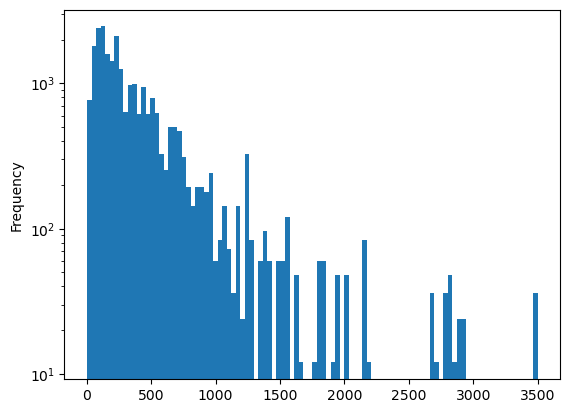

In [ ]:
# 1) 면적이 극단적으로 작은 행정동이 최대치 만들었는지
display(fi_df.nlargest(50, '용적률_행정동별')[['자치구','ADM_NM','행정동면적','건물연면적','용적률_행정동별']])

# 2) 로그 스케일 히스토그램으로 분포
fi_df['용적률_행정동별'].plot.hist(bins=100, log=True)

# fi_df.to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\용적률컬럼추가.csv", index=False, encoding='utf-8-sig')

### 후처리 시행착오

In [6]:
import pandas as pd
df_m = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\최종_행정동_연도별_면적.csv")
df_mapping = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\용적률_최종\법정동_행정동_매핑.csv")
df_mapping.rename(columns={'행정동명':'ADM_NM'}, inplace=True)
df_m.merge(df_mapping, on='ADM_NM', how='left')

,자치구,ADM_NM,year,month,행정동면적,행정동코드,법정동코드,법정동명
0,종로구,사직동,2020,1,1.23,1111053000,1111010600,통의동
1,종로구,사직동,2020,1,1.23,1111053000,1111010700,적선동
2,종로구,사직동,2020,1,1.23,1111053000,1111011200,체부동
3,종로구,사직동,2020,1,1.23,1111053000,1111011300,필운동
4,종로구,사직동,2020,1,1.23,1111053000,1111011400,내자동
...,...,...,...,...,...,...,...,...
44755,강동구,상일2동,2024,8,1.09,1174052600,1174010300,상일동
44756,강동구,상일2동,2024,9,1.09,1174052600,1174010300,상일동
44757,강동구,상일2동,2024,10,1.09,1174052600,1174010300,상일동
44758,강동구,상일2동,2024,11,1.09,1174052600,1174010300,상일동


In [ ]:
df_m.info()

df_m의 ADM_NM과 df_mapping의 행정동명 컬럼이 같아. 따라서, 저 컬럼을 기준으로, df_m에 left조인으로, df_mapping의 행정동코드를 붙이는 코드
그거를 df_m으로 재정의해줘
이후, 
final_df와 결합하는데, 결합 대상 컬럼을 '행정동코드','ADM_NM','year','month' 로 해서 자치구도 반영되도록
df_m.merge(df_mapping, on='행정동코드')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25560 entries, 0 to 25559
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   자치구     25560 non-null  object 
 1   ADM_NM  25560 non-null  object 
 2   year    25560 non-null  int64  
 3   month   25560 non-null  int64  
 4   행정동면적   25560 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 998.6+ KB


In [ ]:
print(final_df.columns)
print(df_m.columns)
print(df_mapping.columns)
k = df_m.merge(df_mapping, on=['행정동코드','ADM_NM','year','month'],how='left')

Index(['행정동코드', '행정동명', 'year', 'month', '건물연면적'], dtype='object')
Index(['자치구', 'ADM_NM', 'year', 'month', '행정동면적'], dtype='object')
Index(['행정동코드', 'ADM_NM', '법정동코드', '법정동명'], dtype='object')


In [92]:
keys = ['ADM_NM','year','month']
df_m[df_m.duplicated(subset=keys, keep=False)].sort_values(keys).head()



,자치구,ADM_NM,year,month,행정동면적
3948,관악구,신사동,2020,1,0.64
4296,강남구,신사동,2020,1,1.89
3949,관악구,신사동,2020,2,0.64
4297,강남구,신사동,2020,2,1.89
3950,관악구,신사동,2020,3,0.64


In [100]:
df_mapping.info()
df_mapping.loc[df_mapping['행정동명'] == '신사동']
df_m.loc[df_m['ADM_NM'] == '신사동']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 743 entries, 0 to 742
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   법정동코드   743 non-null    object
 1   행정동코드   743 non-null    object
 2   행정동명    743 non-null    object
dtypes: object(3)
memory usage: 17.5+ KB


,자치구,ADM_NM,year,month,행정동면적
3948,관악구,신사동,2020,1,0.64
3949,관악구,신사동,2020,2,0.64
3950,관악구,신사동,2020,3,0.64
3951,관악구,신사동,2020,4,0.64
3952,관악구,신사동,2020,5,0.64
...,...,...,...,...,...
24751,강남구,신사동,2024,8,1.89
24752,강남구,신사동,2024,9,1.89
24753,강남구,신사동,2024,10,1.89
24754,강남구,신사동,2024,11,1.89


In [99]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25560 entries, 0 to 25559
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   자치구     25560 non-null  object 
 1   ADM_NM  25560 non-null  object 
 2   year    25560 non-null  int64  
 3   month   25560 non-null  int64  
 4   행정동면적   25560 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 998.6+ KB


In [93]:
final_df[final_df.duplicated(subset=keys, keep=False)].sort_values(keys).head(30)


,행정동코드,ADM_NM,year,month,건물연면적
19920,1162068500,신사동,2020,1,1.001053e+07
21480,1168051000,신사동,2020,1,4.288390e+06
19921,1162068500,신사동,2020,2,1.001053e+07
21481,1168051000,신사동,2020,2,4.288390e+06
19922,1162068500,신사동,2020,3,1.001053e+07
21482,1168051000,신사동,2020,3,4.288390e+06
19923,1162068500,신사동,2020,4,1.001053e+07
21483,1168051000,신사동,2020,4,4.288390e+06
19924,1162068500,신사동,2020,5,1.001053e+07
21484,1168051000,신사동,2020,5,4.288390e+06


In [108]:
import pandas as pd

# -------------------------------------------------
# 0) 전제: df_m, df_mapping, final_df 가 이미 메모리에 있다고 가정
#    df_mapping 에는 '행정동명', '행정동코드', '자치구' 같은 정보가 들어 있음
# -------------------------------------------------

df_m = df_m.merge(df_mapping[['행정동명','행정동코드']], left_on='ADM_NM', right_on='행정동명', how='left').drop(columns='행정동명')
fffi_df = df_m.merge(final_df, on=['행정동코드','ADM_NM','year','month'], how='left')


# 3. 행정동 연도별 면적 값을 컬럼으로 가지는 테이블 생성
- 최종 영향 변수 생성 시 활용 목적

In [49]:
df_m = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\행정동_년도별_면적.csv") 

In [ ]:
# dff(기준 테이블) 불러오기
dff = pd.read_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\landsat8_추출_데이터\lst_final_20_24.csv")

# ADM_NM 유일값 비교
set1 = set(dff['ADM_NM'].dropna().unique())
set2 = set(df_m['ADM_NM'].dropna().unique())

if set1 == set2:
    print("두 데이터프레임의 ADM_NM 유일값이 동일합니다. 총 개수:", len(set1))
else:
    only_in_df = sorted(set1 - set2)
    only_in_df2 = sorted(set2 - set1)
    print("유일값이 다릅니다.")
    print(f"dff에만 있는 값 ({len(only_in_df)}):", only_in_df)
    print(f"df_m에만 있는 값 ({len(only_in_df2)}):", only_in_df2)

유일값이 다릅니다.
dff에만 있는 값 (7): ['금호2·3가동', '면목3·8동', '상계3·4동', '상계6·7동', '종로1·2·3·4가동', '종로5·6가동', '중계2·3동']
df_m에만 있는 값 (7): ['금호2.3가동', '면목3.8동', '상계3.4동', '상계6.7동', '종로1.2.3.4가동', '종로5.6가동', '중계2.3동']


In [51]:
import re

# 1) 숫자 사이의 점(.)을 가운데점(·)으로 바꾸기 (일반적 방법)
df_m['ADM_NM'] = df_m['ADM_NM'].astype(str).str.replace(r'(?<=\d)\.(?=\d)', '·', regex=True)

# 2) 안전하게 특정 값만 치환하려면 (추가 보완)
mapping = {
    '금호2.3가동': '금호2·3가동',
    '면목3.8동': '면목3·8동',
    '상계3.4동': '상계3·4동',
    '상계6.7동': '상계6·7동',
    '종로1.2.3.4가동': '종로1·2·3·4가동',
    '종로5.6가동': '종로5·6가동',
    '중계2.3동': '중계2·3동'
}

df_m['ADM_NM'] = df_m['ADM_NM'].replace(mapping)

# 확인
set1 = set(dff['ADM_NM'].dropna().unique())
set2 = set(df_m['ADM_NM'].dropna().unique())
print("dff에만 있는 값:", sorted(list(set1 - set2)))
print("df_m에만 있는 값:", sorted(list(set2 - set1)))
# ...existing code...

dff에만 있는 값: []
df_m에만 있는 값: []


In [52]:
df_m['ADM_NM'].unique()

array(['사직동', '삼청동', '부암동', '평창동', '무악동', '교남동', '가회동', '종로1·2·3·4가동',
       '종로5·6가동', '이화동', '혜화동', '창신1동', '창신2동', '창신3동', '숭인1동', '숭인2동',
       '청운효자동', '소공동', '회현동', '명동', '필동', '장충동', '광희동', '을지로동', '신당5동',
       '황학동', '중림동', '신당동', '다산동', '약수동', '청구동', '동화동', '후암동', '용산2가동',
       '남영동', '원효로2동', '효창동', '용문동', '이촌1동', '이촌2동', '이태원1동', '이태원2동',
       '서빙고동', '보광동', '청파동', '원효로1동', '한강로동', '한남동', '왕십리2동', '마장동',
       '사근동', '행당1동', '행당2동', '응봉동', '금호1가동', '금호4가동', '성수1가1동', '성수1가2동',
       '성수2가1동', '성수2가3동', '송정동', '용답동', '왕십리도선동', '금호2·3가동', '옥수동',
       '화양동', '군자동', '중곡1동', '중곡2동', '중곡3동', '중곡4동', '능동', '구의1동', '구의2동',
       '구의3동', '광장동', '자양1동', '자양2동', '자양3동', '자양4동', '회기동', '휘경1동',
       '휘경2동', '청량리동', '용신동', '제기동', '전농1동', '전농2동', '답십리1동', '답십리2동',
       '장안1동', '장안2동', '이문1동', '이문2동', '면목2동', '면목4동', '면목5동', '면목7동',
       '상봉1동', '상봉2동', '중화1동', '중화2동', '묵1동', '묵2동', '망우3동', '신내1동',
       '신내2동', '면목본동', '면목3·8동', '망우본동', '돈암1동', '돈암2동', '안암동', '보문동',
   

In [ ]:
# 행정동 면적 데이터프레임 전처리 스크립트
import pandas as pd

# df : 현재 가진 wide 형태의 데이터프레임
# 컬럼 구조 예: ['자치구', 'ADM_NM', '2020', '2021', '2022', '2023', '2024']

# -------- 1) wide → long 변환 (연도 풀기) --------
df_long = df_m.melt(
    id_vars=['자치구', 'ADM_NM'],     # 고정 컬럼
    value_vars=['2020','2021','2022','2023','2024'],     # 펼칠 연도 컬럼
    var_name='year',
    value_name='행정동면적'
)

# -------- 2) month 생성 (각 연도당 12개월 복제) --------
# month = 1~12 반복
df_long = df_long.loc[df_long.index.repeat(12)].reset_index(drop=True)
df_long['month'] = df_long.groupby(['자치구','ADM_NM','year']).cumcount() + 1

# year를 숫자로 변환(문자일 경우)
df_long['year'] = df_long['year'].astype(int)

# -------- 3) 최종 컬럼 순서 정렬 --------
df_final = df_long[['자치구','ADM_NM','year','month','행정동면적']]

# 저장
# df_final.to_csv(r"C:\Users\cub72\Desktop\2025-2\시스템분석\dataset\최종_행정동_연도별_면적.csv", index=False, encoding='utf-8-sig')